# "Chapter 6: Design Patterns with First-Class Functions"

> functions are just another object

- toc:true
- badges: true
- author: JJmachan

Your language of choice has a lot impact on the Design patterns you choose and how exactly they are implemented. Since in python, functions are first class object, that brings about a lot of change in how you implement the classic design patterns. You can use function to build less verbose version of these same patterns. And the book shows this with the "Strategy Pattern" as an example

## Case Study: Refactoring "Strategy Pattern"

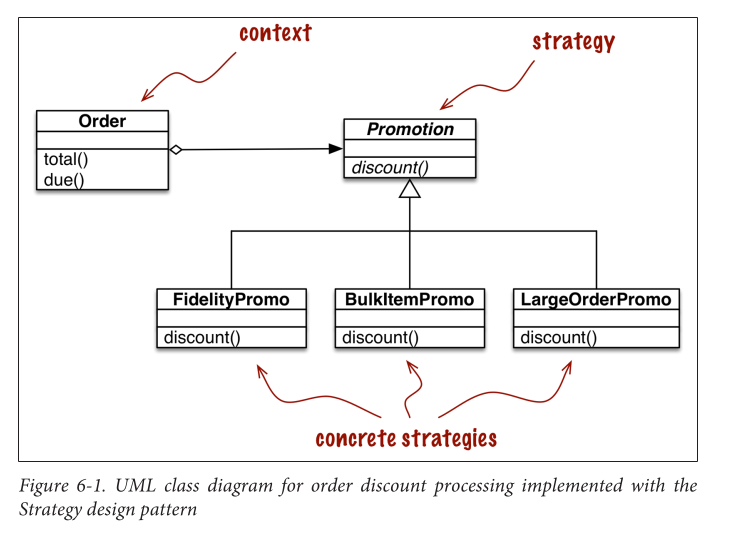

Do refer the book if you want to know more about the pattern but here is the code for how you would implement it in python.

In [1]:
from abc import ABC, abstractmethod
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')

class LineItem:
    "The individual items in the cart."
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
    def total(self):
        return self.price * self.quantity
    
class Order: # the Context
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due()) 

class Promotion(ABC):
# the Strategy: an abstract base class
    @abstractmethod
    def discount(self, order):
        """Return discount as a positive dollar amount"""

    
class FidelityPromo(Promotion): # first Concrete Strategy
    """5% discount for customers with 1000 or more fidelity points"""
    def discount(self, order):
        return order.total() * .05 if order.customer.fidelity >= 1000 else 0

class BulkItemPromo(Promotion): # second Concrete Strategy
    """10% discount for each LineItem with 20 or more units"""
    def discount(self, order):
        discount = 0
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * .1
        return discount

class LargeOrderPromo(Promotion): # third Concrete Strategy
    """7% discount for orders with 10 or more distinct items"""
    def discount(self, order):
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * .07
        return 0

In [2]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = [LineItem('banana', 4, .5),
        LineItem('apple', 10, 1.5),
        LineItem('watermellon', 5, 5.0)]
Order(joe, cart, FidelityPromo())

<Order total: 42.00 due: 42.00>

In [3]:
Order(ann, cart, FidelityPromo())

<Order total: 42.00 due: 39.90>

In [4]:
banana_cart = [LineItem('banana', 30, .5),
               LineItem('apple', 10, 1.5)]
Order(joe, banana_cart, BulkItemPromo())

<Order total: 30.00 due: 28.50>

In [5]:
long_order = [LineItem(str(item_code), 1, 1.0)
              for item_code in range(10)]
Order(joe, long_order, LargeOrderPromo())

<Order total: 10.00 due: 9.30>

In [6]:
Order(joe, cart, LargeOrderPromo())

<Order total: 42.00 due: 42.00>

This works very well but let's modify it to work better using functions as objects. Here the strategy instances (classes implementing promo codes) have no state and work as plain old functions. Hence we can refractor them out into functions

In [8]:
from collections import namedtuple

Customer = namedtuple('Customer', 'name fidelity')

class LineItem:
    
    def __init__(self, product, quantity, price):
        self.product = product
        self.quantity = quantity
        self.price = price
        
    def total(self):
        return self.price * self.quantity
    
class Order: 
    def __init__(self, customer, cart, promotion=None):
        self.customer = customer
        self.cart = list(cart)
        self.promotion = promotion
        
    def total(self):
        if not hasattr(self, '__total'):
            self.__total = sum(item.total() for item in self.cart)
        return self.__total
    
    def due(self):
        if self.promotion is None:
            discount = 0
        else:
            discount = self.promotion(self)
        return self.total() - discount
    
    def __repr__(self):
        fmt = '<Order total: {:.2f} due: {:.2f}>'
        return fmt.format(self.total(), self.due())
    
def fidelity_promo(order):
    """5% discount for customers with 1000 or more fidelity points"""
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0

def bulk_item_promo(order):
    """10% discount for each LineItem with 20 or more units"""
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount

def large_order_promo(order):
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

In [10]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = [LineItem('banana', 4, .5),
        LineItem('apple', 1000, 1.5),
        LineItem('watermellon', 5, 5.0)]
Order(ann, cart, fidelity_promo)

<Order total: 1527.00 due: 1450.65>

As you can see the proper use of functions eleminates the use of classes with single methods. these stategies are also reusable and can be called from the module from which it is defined. 

Now there are some reasons why we were able to reduce the classes to functions
1. They were classes with only 1 function
2. They had no state

Now lets implement a meta stategy to find the best promo available.

In [11]:
promos = [fidelity_promo, 
          bulk_item_promo, 
          large_order_promo]

In [12]:
def best_promo(order):
    """Select the best discount available"""
    return max(promo(order) for promo in promos)

In [13]:
Order(joe, cart, best_promo)

<Order total: 1527.00 due: 1377.00>

This works quite well but there is a bit of duplication involved. Each time we create a new function we have to add it into the `promos` list. If it's not added then it does not get used. 

Now lets see a couple of solutions to fix that. 

In [14]:
def test_promo(self):
    pass

# somewhat hackish sol using the globals()
promos = [globals()[name] for name in globals()
             if name.endswith('_promo')
             and name != 'best_promo']

In [15]:
promos

[<function __main__.fidelity_promo(order)>,
 <function __main__.bulk_item_promo(order)>,
 <function __main__.large_order_promo(order)>,
 <function __main__.test_promo(self)>]

Another way is to move all the module to a new module and using `inspect` get all the members.

In [22]:
import inspect 

class promotions:
    def test_promo(self):
        ...
        
    def another_promo(self):
        ...
    
promos = [func for name, func in 
             inspect.getmembers(promotions, inspect.isfunction)]

In [23]:
promos

[<function __main__.promotions.another_promo(self)>,
 <function __main__.promotions.test_promo(self)>]

Now another possiblity is to use `decorators` which IMO is a must cleaner implementation. (More on Chapter 7)

## Command

Command is another design pattern that can be simplified by the use of functions passed as arguments. The goal of the Comamand is to decouple the object than invokes an operation (the Invoker) from the provider object that implements it (the Receiver).

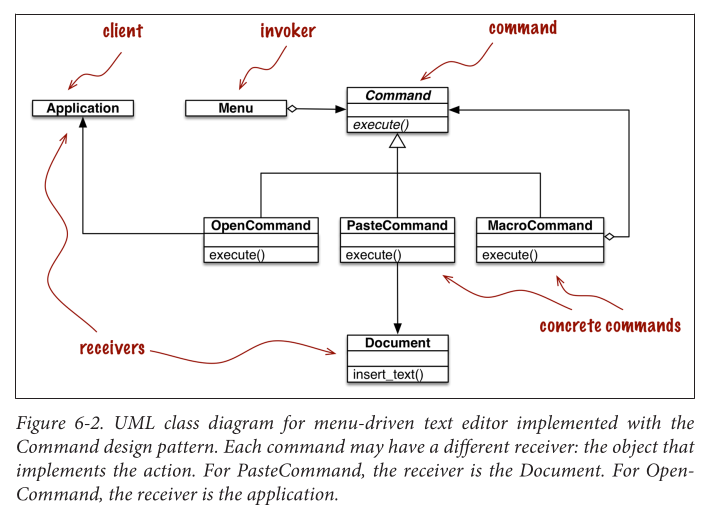

Now simple way to implement this is with callbacks. Each Command can be implemented as a class which contains the list of commands that has to be executed. Defining a `__call__` in it will create a callable object.

In [22]:
class MacroCommand:
    """ A command that executes a list of commands"""
    
    def __init__(self, commands):
        self.commands = list(commands)
        
    def __call__(self):
        for command in self.commands:
            command()